# TEAM-KMJS (a.k.a Team Sasa)     
### Sprint4 - News 

In [1]:
import spacy
import en_core_web_lg

import gensim 
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

import pyLDAvis.gensim

import numpy as np 
import pandas as pd
import math 

import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob 
# https://www.loc.gov/standards/iso639-2/php/code_list.php

from collections import  Counter
import string, os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Optiplex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Optiplex\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Optiplex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
print(f'SpaCy:\t{spacy.__version__}')
print(f'en_core_web_lg:\t{en_core_web_lg.__version__}')
print(f'NLTK:\t{nltk.__version__}')
print(f'gensim:\t{gensim.__version__}')

SpaCy:	3.0.3
en_core_web_lg:	3.0.0
NLTK:	3.5
gensim:	3.8.3


In [6]:

### NLP Model
# NLP = en_core_web_lg.load()
NLP = spacy.load('en_core_web_lg', disable=['parser', 'ner'])


### Stop Words
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['news', 'advertisement', 'rappler', 'gma', 'inquirer', 'manila', 'philippines', 'philippine', 'bulletin', 'star',\
    'cnn', 'abs', 'cbn', 'abscbn', 'abs-cbn', 'sunstar', 'covid', 'covid-19', 'covid19', 'vaccine', 'say'])
TAGALOG = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ii
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

STOPWORDS.extend(TAGALOG)
print(STOPWORDS)

### Doc Object
def get_doc(text):
    docstring =  str(''.join([i if ord(i) < 128 else ' ' for i in text]))
    return NLP(docstring)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
FILENAME = 'datasets/combined_and_cleaned.csv'

df = pd.read_csv(FILENAME)
# df['published_dates'] = pd.to_datetime(df['published_dates'])
df['authors'].fillna('sunstar', inplace=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   urls              2528 non-null   object
 1   titles            2528 non-null   object
 2   authors           2528 non-null   object
 3   published_dates   2528 non-null   object
 4   articles_content  2528 non-null   object
 5   news_org          2528 non-null   object
dtypes: object(6)
memory usage: 118.6+ KB


,urls,titles,authors,published_dates,articles_content,news_org
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\r\nThe Philippine governme...",Rappler
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\r\n(UPDATED) On March 1, t...",Rappler
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\r\n(UPDATED) Malacañang sa...",Rappler
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\r\n(UPDATED) Its lower eff...",Rappler
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\r\n(3rd UPDATE) The arriva...",Rappler
...,...,...,...,...,...,...
2523,https://mb.com.ph/2020/03/07/virus-folding-puz...,Virus-folding puzzle game might help find vacc...,manilabulletin_admin,"March 7, 2020, 12:00 AM",By Rizal ObanilThis development has the making...,manilabulletin
2524,https://mb.com.ph/2020/02/25/needed-vaccine-in...,Needed: vaccine & info on how Covid-1 spreads,manilabulletin_admin,"February 25, 2020, 12:00 AM","The search for a vaccine for the coronavirus, ...",manilabulletin
2525,https://mb.com.ph/2020/02/22/phap-to-immediate...,PHAP to immediately bring new COVID-19 vaccine...,manilabulletin_admin,"February 22, 2020, 12:00 AM",By Bernie Cahiles-MagkilatThe Pharmaceutical A...,manilabulletin
2526,https://mb.com.ph/2020/02/14/as-scientists-rac...,As scientists race to produce Covid-19 vaccine...,manilabulletin_admin,"February 14, 2020, 12:00 AM",By Analou De VeraAn official of the World Heal...,manilabulletin


# TOPIC MODELING
### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Tokenize words and Clean-up text


In [12]:
# Convert to list
data = df['articles_content'].values.tolist()

# Convert R&D to Research and Development
data = [sent.lower().replace('r&d', 'Research and Development') for sent in data]

# Remove URLs
data = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", '', sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# # Remove underscore characters
# data = [re.sub('(_)', ' ', sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = list(sent_to_words(data))

print(data[:1])

[['manila', 'philippines', 'the', 'philippine', 'government', 'needs', 'key', 'measure', 'on', 'indemnification', 'funds', 'to', 'be', 'signed', 'into', 'law', 'philippine', 'pandemic', 'officials', 'announced', 'the', 'delivery', 'of', 'the', 'country', 'first', 'batch', 'of', 'coronavirus', 'vaccines', 'could', 'be', 'expected', 'by', 'mid', 'february', 'but', 'with', 'that', 'timeline', 'looking', 'less', 'likely', 'to', 'be', 'met', 'the', 'duterte', 'government', 'task', 'force', 'officials', 'announced', 'there', 'would', 'be', 'slight', 'delay', 'in', 'the', 'arrival', 'of', 'vaccines', 'due', 'to', 'of', 'all', 'things', 'paperwork', 'vaccine', 'czar', 'carlito', 'galvez', 'jr', 'and', 'national', 'task', 'force', 'covid', 'deputy', 'chief', 'implementer', 'vince', 'dizon', 'pointed', 'to', 'documentary', 'requirements', 'involving', 'an', 'indemnification', 'fund', 'as', 'the', 'culprit', 'behind', 'the', 'delayed', 'schedule', 'why', 'do', 'we', 'need', 'an', 'indemnification

## Creating Bigram and Trigram Models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

['manila', 'philippines', 'the', 'philippine', 'government', 'needs', 'key', 'measure', 'on', 'indemnification', 'funds', 'to', 'be', 'signed', 'into', 'law', 'philippine', 'pandemic', 'officials', 'announced', 'the', 'delivery', 'of', 'the', 'country', 'first', 'batch', 'of', 'coronavirus', 'vaccines', 'could', 'be', 'expected', 'by', 'mid_february', 'but', 'with', 'that', 'timeline', 'looking', 'less', 'likely', 'to', 'be', 'met', 'the', 'duterte', 'government', 'task_force', 'officials', 'announced', 'there', 'would', 'be', 'slight', 'delay', 'in', 'the', 'arrival', 'of', 'vaccines', 'due', 'to', 'of', 'all', 'things', 'paperwork', 'vaccine', 'czar_carlito_galvez_jr', 'and', 'national', 'task_force', 'covid', 'deputy_chief_implementer_vince', 'dizon', 'pointed', 'to', 'documentary_requirements', 'involving', 'an', 'indemnification_fund', 'as', 'the', 'culprit', 'behind', 'the', 'delayed', 'schedule', 'why', 'do', 'we', 'need', 'an', 'indemnification_fund', 'an', 'indemnification_fun

## Remove Stopwords, Make Bigrams and Lemmatize


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = NLP(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [15]:
# Do lemmatization keeping only noun, adj, vb, adv
data = lemmatization(data)

# Remove Stop Words
data = remove_stopwords(data)
# data = remove_stopwords(data)
# data = remove_stopwords(data)

# Form Bigrams | Trigrams
data = make_bigrams(data)

#### NOTE: lemmatization was move to first pass
# # Do lemmatization keeping only noun, adj, vb, adv
# data = lemmatization(data)

print(data[:1])

[['government', 'need', 'key', 'measure', 'indemnification_fund', 'sign', 'law', 'pandemic', 'official', 'announce', 'delivery', 'country', 'first', 'batch', 'coronavirus', 'expect', 'mid_february', 'timeline', 'look', 'less', 'likely', 'meet', 'duterte', 'government', 'task_force', 'official', 'announce', 'slight', 'delay', 'arrival', 'thing', 'paperwork', 'czar', 'galvez_jr', 'national', 'task_force', 'deputy_chief', 'implementer_vince', 'dizon', 'point', 'documentary', 'requirement', 'involve', 'indemnification_fund', 'culprit', 'delay', 'schedule', 'need', 'indemnification_fund', 'indemnification_fund', 'galvez', 'early', 'tell', 'lawmaker', 'congressional', 'hearing', 'necessary', 'gain_access', 'dose', 'pharmaceutical_company', 'well', 'global', 'facility', 'request', 'lawmaker', 'consider', 'bill', 'provide', 'mid', 'january', 'add', 'give', 'opportunity', 'gain_access', 'large', 'supply', 'increase', 'public', 'confidence', 'government', 'rollout', 'reason', 'indemnification_fu

### Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
# Create Dictionary
id2word_dictionary = Dictionary(data)

# Create Corpus
texts = data

# Term Document Frequency
corpus = [id2word_dictionary.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
# [(id2word_dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 3), (10, 4), (11, 1), (12, 8), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 5), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 3), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 12), (42, 1), (43, 5), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 3), (58, 1), (59, 1), (60, 1), (61, 1), (62, 9), (63, 1), (64, 2), (65, 3), (66, 1), (67, 1), (68, 1), (69, 1), (70, 6), (71, 3), (72, 1), (73, 3), (74, 1), (75, 2), (76, 1), (77, 1), (78, 3), (79, 1), (80, 2), (81, 3), (82, 2), (83, 1), (84, 1), (85, 1), (86, 3), (87, 1), (88, 2), (89, 3), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 2), (104, 1), (105, 2), (106, 2), (107, 3), (108, 4), (109, 1), (110, 1

## Building the Topic Model

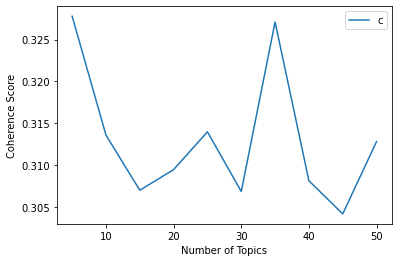

Model[0] ~> N-Topics ~>  5 has Coherence Value of ~> 0.3278
Model[1] ~> N-Topics ~> 10 has Coherence Value of ~> 0.3136
Model[2] ~> N-Topics ~> 15 has Coherence Value of ~> 0.307
Model[3] ~> N-Topics ~> 20 has Coherence Value of ~> 0.3095
Model[4] ~> N-Topics ~> 25 has Coherence Value of ~> 0.314
Model[5] ~> N-Topics ~> 30 has Coherence Value of ~> 0.3069
Model[6] ~> N-Topics ~> 35 has Coherence Value of ~> 0.3271
Model[7] ~> N-Topics ~> 40 has Coherence Value of ~> 0.3082
Model[8] ~> N-Topics ~> 45 has Coherence Value of ~> 0.3042
Model[9] ~> N-Topics ~> 50 has Coherence Value of ~> 0.3128
CPU times: user 2min 34s, sys: 40.9 s, total: 3min 15s
Wall time: 3min 47s


In [10]:
%%time 

limit = 51; start = 5; step = 5
coherences = []
models = []

for N in range(start, limit, step):
    ldamodel = LdaModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary)
    models.append(ldamodel)

    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
    ldacoherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    coherences.append((ldacoherence))


# Plot the number of topics based on coherence score
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend('coherences', loc='best')
plt.show()  


# Print the coherence scores
idx = 0
for n, cv in zip(x, coherences):
    print(f'Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

In [ ]:
# INTENTIONAL EXCEPTION
raise Exception('Select the BEST MODEL')

In [26]:
# Select the BEST model and print the topics
best_model = models[2]
topics = best_model.show_topics(formatted=False)
best_model.print_topics(num_words=10)

[(0,
  '0.026*"say" + 0.015*"vaccine" + 0.014*"vaccination" + 0.012*"dose" + 0.010*"city" + 0.009*"first" + 0.008*"government" + 0.005*"health" + 0.005*"also" + 0.005*"country"'),
 (1,
  '0.023*"say" + 0.015*"vaccine" + 0.011*"dose" + 0.011*"government" + 0.009*"city" + 0.008*"also" + 0.007*"health" + 0.007*"vaccination" + 0.007*"astrazeneca" + 0.005*"national"'),
 (2,
  '0.027*"say" + 0.016*"vaccine" + 0.011*"dose" + 0.008*"government" + 0.007*"health" + 0.007*"country" + 0.006*"vaccination" + 0.006*"also" + 0.005*"astrazeneca" + 0.005*"city"'),
 (3,
  '0.014*"say" + 0.010*"health" + 0.008*"pfizer" + 0.008*"dose" + 0.007*"vaccine" + 0.007*"government" + 0.006*"city" + 0.006*"first" + 0.005*"also" + 0.005*"country"'),
 (4,
  '0.025*"say" + 0.015*"vaccination" + 0.014*"vaccine" + 0.012*"health" + 0.011*"city" + 0.009*"dose" + 0.008*"government" + 0.007*"vaccinate" + 0.006*"astrazeneca" + 0.006*"program"'),
 (5,
  '0.026*"say" + 0.016*"health" + 0.013*"city" + 0.011*"vaccine" + 0.008*"al

In [17]:
## SHORTCUT TO BESTMODEL rather than running 51 loop
best_model = LdaModel(corpus=corpus, num_topics=15, id2word=id2word_dictionary)
topics = best_model.show_topics(formatted=False)

In [53]:

# from collections import Counter
# import matplotlib.colors as mcolors


# data_flat = [w for w_list in data for w in w_list]
# counter = Counter(data_flat)

# out = []
# for i, topic in topics:
#     for word, weight in topic:
#         out.append([word, i , weight, counter[word]])

# dff = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# # Plot Word Count and Weights of Topic Keywords
# fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
# for i, ax in enumerate(axes.flatten()):
#     ax.bar(x='word', height="word_count", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
#     ax_twin = ax.twinx()
#     ax_twin.bar(x='word', height="importance", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
#     ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
#     ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
#     ax.tick_params(axis='y', left=False)
#     ax.set_xticklabels(dff.loc[dff.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
#     ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# fig.tight_layout(w_pad=2)    
# fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
# plt.show()
# dff

In [19]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_model, corpus, id2word_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.035034 -0.052265       1        1  17.355037
8     -0.030575  0.018634       2        1  11.629623
6     -0.041598 -0.051610       3        1  10.728355
9     -0.000530  0.004861       4        1   8.736626
5     -0.039768 -0.009615       5        1   8.534401
2      0.090221 -0.021353       6        1   7.431956
13    -0.028138  0.029949       7        1   7.139054
12     0.053089  0.026144       8        1   5.409775
11     0.054177 -0.006023       9        1   4.436639
0     -0.017141  0.009784      10        1   4.263197
7     -0.036086 -0.006293      11        1   3.863412
10    -0.026342 -0.022046      12        1   3.778083
3     -0.037109 -0.001435      13        1   3.125755
4      0.002266  0.046469      14        1   2.727666
1      0.022502  0.034798      15        1   0.840422, topic_info=             Term         Freq        Total Category  logprob  loglift
659          city  4309.000000  4309.000000  Default  30.0000  30.0000
636         trial  2723.000000  2723.000000  Default  29.0000  29.0000
145    government  6943.000000  6943.000000  Default  28.0000  28.0000
739      clinical  1835.000000  1835.000000  Default  27.0000  27.0000
252     president  2583.000000  2583.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1755        mayor     9.812372  1011.647361  Topic15  -6.0640   0.1433
46           case    10.242042  1443.504062  Topic15  -6.0212  -0.1693
28    astrazeneca    10.301873  1588.372168  Topic15  -6.0154  -0.2591
3625      percent    10.214633  1578.685155  Topic15  -6.0239  -0.2615
667       disease    10.142568  1971.420247  Topic15  -6.0309  -0.4907

[1218 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5225      2  0.823066      abandon
5225      3  0.041153      abandon
5225      5  0.041153      abandon
5225      9  0.041153      abandon
354       1  0.080350  abeyasinghe
...     ...       ...          ...
5422      2  0.064054       zoning
5422      3  0.064054       zoning
5422      7  0.064054       zoning
5422     11  0.064054       zoning
5422     12  0.640537       zoning

[4755 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 9, 7, 10, 6, 3, 14, 13, 12, 1, 8, 11, 4, 5, 2])

## Finding the dominant topic in each sentence

In [ ]:
raise Exception("For WordCloud Vis, changed topic keywords to dictionary by weight")

In [20]:
##use this for wordcloud
##simply changed topic keywords to include their weight
##topic keywords now a dictionary
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            topic_keywords = dict()
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                for word, prop in wp:
                    topic_keywords[word] = prop
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_id', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
# df_dominant_topic = df_dominant_topic.drop('document_id', axis=1)

# Show
# print(f'{df_dominant_topic.shape[0]} == {df.shape[0]}')
df_dominant_topic

,document_id,dominant_topic,topic_percentage_contribution,keywords,text
0,0,6.0,0.3358,"{'government': 0.015279688, 'country': 0.01180...","[government, need, key, measure, indemnificati..."
1,1,14.0,0.8739,"{'government': 0.02292523, 'city': 0.014424616...","[update, march, finally, begin, legally, roll,..."
2,2,14.0,0.7087,"{'government': 0.02292523, 'city': 0.014424616...","[update, malacanang, dose, global, facility, h..."
3,3,8.0,0.5591,"{'country': 0.012821958, 'health': 0.009700252...","[update, low, efficacy, trial, brazil, lead, e..."
4,4,14.0,0.4348,"{'government': 0.02292523, 'city': 0.014424616...","[rd, update, arrival, donate, china, pave, way..."
...,...,...,...,...,...
2523,2523,0.0,0.8133,"{'president': 0.014558297, 'duterte': 0.011627...","[rizal, development, makings, good, book, even..."
2524,2524,8.0,0.3332,"{'country': 0.012821958, 'health': 0.009700252...","[search, coronavirus, name, world, health, org..."
2525,2525,8.0,0.9970,"{'country': 0.012821958, 'health': 0.009700252...","[pharmaceutical, association, represent, resea..."
2526,2526,8.0,0.9574,"{'country': 0.012821958, 'health': 0.009700252...","[analou, veraan, official, world, health, orga..."


In [17]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_id', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
# df_dominant_topic = df_dominant_topic.drop('document_id', axis=1)

# Show
# print(f'{df_dominant_topic.shape[0]} == {df.shape[0]}')
df_dominant_topic

,document_id,dominant_topic,topic_percentage_contribution,keywords,text
0,0,2.0,0.4805,"say, vaccine, dose, government, health, countr...","[government, need, key, measure, indemnificati..."
1,1,7.0,0.5674,"say, vaccine, city, government, health, dose, ...","[update, march, finally, begin, legally, roll,..."
2,2,7.0,0.5367,"say, vaccine, city, government, health, dose, ...","[update, malacanang, say, dose, covax, global,..."
3,3,9.0,0.4395,"say, vaccine, dose, first, country, health, al...","[update, low, efficacy, trial, lead, expert, r..."
4,4,4.0,0.6843,"say, vaccination, vaccine, health, city, dose,...","[rd, update, arrival, donate, vaccine, china, ..."
...,...,...,...,...,...
1493,1493,14.0,0.8315,"say, vaccine, dose, also, get, country, first,...","[zamboanga, city, write, education, brione, re..."
1494,1494,8.0,0.9887,"say, city, government, health, vaccine, get, c...","[zamboanga, city, mayor, convene, pantalan, ta..."
1495,1495,12.0,0.9881,"say, government, city, health, vaccination, va...","[zamboangueno, athlete, reap, medal, recent, n..."
1496,1496,6.0,0.9236,"say, city, health, vaccine, government, also, ...","[delegation, zamboanga, city, recently, conclu..."


## Find the most representative document for each topic

In [37]:
# Group top N sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['percentage_contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['topic_id', "topic_percentage_contribution", "keywords", "text"]

# ### Save the dataset as CSV
# sent_topics_sorteddf.to_csv('datasets/topics.csv')

##save to csv when changed keywords to frequencies
##sent_topics_sorteddf.to_csv("datasets/wordcloud_topics.csv")
# Show
print(sent_topics_sorteddf.shape)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf

(15, 4)


,topic_id,topic_percentage_contribution,keywords,text
0,0.0,0.9963,"{'president': 0.014558297, 'duterte': 0.011627669, 'filipino': 0.010073355, 'percent': 0.009449525, 'government': 0.008958487, 'coronavirus': 0.007891093, 'get': 0.00782184, 'country': 0.006094649, 'also': 0.0060848747, 'first': 0.005909425}","[bong_go, president, duterte, file_photo, senator, bong_go, eye, presidential, seat, next, year, president, duterte, make, announcement, introduce, go, inauguration, newly, construct, port, operation, building, port, dumaguete, dumaguete, city, negro, oriental, speech, go, ask, favor, tell, public, lawmaker, suppose, plan, join, presidential, race, senator, bong_go, eroplano, sir, hingin, sana, sayo, pabor, medyo, leave, bad, taste, mouth, lang, mag, totoo, talaga, bagay, daw, inyo, president, senator, bong_go, disembark, plane, sir, favor, ask, ask, somehow, leave, bad, taste, mouth, still, far, want, tell, tell, truth, want, tell, want, president, duterte, draw, cheer, crowd, however, unclear, serious, make, remark, go, join, event, see, shake, head, ...]"
1,1.0,0.9916,"{'government': 0.0137846125, 'city': 0.010932673, 'trial': 0.0074342457, 'vaccination': 0.0066286847, 'country': 0.0066221016, 'health': 0.0062681558, 'national': 0.0061931973, 'clinical': 0.0053823455, 'also': 0.0047285235, 'people': 0.004541917}","[retailer, family, specialty, clinic, fvsc, ip_biotech, ambica_international, corporation, sign, exclusive, agreement, bharat_biotech, international, ltd, import, distribute, india, candidate, completion, ongoing, phase, clinical, trial, food, drug_administration, fda, approval, photo, afp_file, photo, fvsc, operate, clinic, country, work, closely, network, local, government, unit, vaccination, initiative, international, corp, meanwhile, large, pharmaceutical_company, product, portfolio, partnership, enable, access, covaxin, near, future, international, goal, provide, great, accessibility, essential, healthcare, product, improve, wellbeing, filipino, nation, partnership, bharat_biotech, international, ip_biotech, distribution, covaxin, testament, international, statement, india, indigenous, bharat_biotech, develop, collaboration, indian, council, medical, research, icmr, national, institute, virology, niv, develop, manufacture, bharat_biotech, bsl, bio, safety, level, bio, containment, facility, ...]"
2,2.0,0.9957,"{'city': 0.031660516, 'government': 0.027383182, 'health': 0.014612305, 'vaccination': 0.011096766, 'also': 0.010993741, 'local': 0.010649736, 'national': 0.010339879, 'resident': 0.007808283, 'mayor': 0.0073704645, 'case': 0.0070177894}","[mayor, francisco, domagoso, reiterate, call, resident, city, continue, follow, government, issue, health, protocol, wait, mayor, francisco, facebook, file_photo, true, already, bakuna, wala, po, paghahanda, yan, darate, linggo, country, program, prepare, come, week, month, weekly, capital, report, january, meantime, patuloy, kayong, magmalasakit, kayo, nang, kusa, national, government, local, government, continue, take, care, voluntarily, follow, guideline, issue, national, local, government, regard, health, protocol, add, datum, city, government, show, active, case, confirm, case, capital, city, sunday, figure, recover, die, city, government, also, sustain, free, swab_testing, effort, resident, non, resident, city, january, already, test, people, meanwhile, people, swab, city, government, balik, maynila, free, swab_testing, ...]"
3,3.0,0.9957,"{'country': 0.011952396, 'trial': 0.009206621, 'government': 0.008897291, 'health': 0.007643899, 'president': 0.007288349, 'also': 0.006840913, 'dose': 0.0066669243, 'duterte': 0.0062551806, 'china': 0.0061002583, 'sinovac': 0.006087839}","[update, develop, china, back, pharmaceutical_company, sinovac, arrive, early, next, month, beijing, envoy, confirm, friday, cite, new, era, partnership, country, pandemic, expect, china, sinovac, arrive, early, next, month, joint, anti, pandemic, response, past, year, enrich, strength

## Topic distribution across documents

In [38]:
pd.reset_option('^display', silent=True)

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['dominant_topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['dominant_topic', 'topic_keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['dominant_topic', 'topic_keywords', 'num_documents', 'percentage_documents']

# Show
# df_dominant_topics = df_dominant_topics[~df_dominant_topics['num_documents'].isna()][['topic_keywords']]
df_dominant_topics

,dominant_topic,topic_keywords,num_documents,percentage_documents
0.0,6.0,"{'government': 0.015279688, 'country': 0.01180...",104.0,0.0411
1.0,14.0,"{'government': 0.02292523, 'city': 0.014424616...",29.0,0.0115
2.0,14.0,"{'government': 0.02292523, 'city': 0.014424616...",221.0,0.0874
3.0,8.0,"{'country': 0.012821958, 'health': 0.009700252...",67.0,0.0265
4.0,14.0,"{'government': 0.02292523, 'city': 0.014424616...",60.0,0.0237
...,...,...,...,...
2523.0,0.0,"{'president': 0.014558297, 'duterte': 0.011627...",NaN,NaN
2524.0,8.0,"{'country': 0.012821958, 'health': 0.009700252...",NaN,NaN
2525.0,8.0,"{'country': 0.012821958, 'health': 0.009700252...",NaN,NaN
2526.0,8.0,"{'country': 0.012821958, 'health': 0.009700252...",NaN,NaN


# FINAL DF

In [39]:
sia = SentimentIntensityAnalyzer()

def get_vader_polarity(text):
    return sia.polarity_scores(text)['compound']

def get_vader_negativity(text):
    return sia.polarity_scores(text)['neg']

def get_vader_neutrality(text):
    return sia.polarity_scores(text)['neu']

def get_vader_positivity(text):
    return sia.polarity_scores(text)['pos']

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_analysis(score):
    if score <= -0.05:
        return 'Negative'
    elif score >= 0.05:
        return 'Positive'
    else:
        return 'Neutral'

In [40]:
df = pd.concat([df, df_dominant_topic.reindex(df.index)], axis=1).drop('document_id', axis=1)
df

,urls,titles,authors,published_dates,articles_content,news_org,dominant_topic,topic_percentage_contribution,keywords,text
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\r\nThe Philippine governme...",Rappler,6.0,0.3358,"{'government': 0.015279688, 'country': 0.01180...","[government, need, key, measure, indemnificati..."
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\r\n(UPDATED) On March 1, t...",Rappler,14.0,0.8739,"{'government': 0.02292523, 'city': 0.014424616...","[update, march, finally, begin, legally, roll,..."
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\r\n(UPDATED) Malacañang sa...",Rappler,14.0,0.7087,"{'government': 0.02292523, 'city': 0.014424616...","[update, malacanang, dose, global, facility, h..."
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\r\n(UPDATED) Its lower eff...",Rappler,8.0,0.5591,"{'country': 0.012821958, 'health': 0.009700252...","[update, low, efficacy, trial, brazil, lead, e..."
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\r\n(3rd UPDATE) The arriva...",Rappler,14.0,0.4348,"{'government': 0.02292523, 'city': 0.014424616...","[rd, update, arrival, donate, china, pave, way..."
...,...,...,...,...,...,...,...,...,...,...
2523,https://mb.com.ph/2020/03/07/virus-folding-puz...,Virus-folding puzzle game might help find vacc...,manilabulletin_admin,"March 7, 2020, 12:00 AM",By Rizal ObanilThis development has the making...,manilabulletin,0.0,0.8133,"{'president': 0.014558297, 'duterte': 0.011627...","[rizal, development, makings, good, book, even..."
2524,https://mb.com.ph/2020/02/25/needed-vaccine-in...,Needed: vaccine & info on how Covid-1 spreads,manilabulletin_admin,"February 25, 2020, 12:00 AM","The search for a vaccine for the coronavirus, ...",manilabulletin,8.0,0.3332,"{'country': 0.012821958, 'health': 0.009700252...","[search, coronavirus, name, world, health, org..."
2525,https://mb.com.ph/2020/02/22/phap-to-immediate...,PHAP to immediately bring new COVID-19 vaccine...,manilabulletin_admin,"February 22, 2020, 12:00 AM",By Bernie Cahiles-MagkilatThe Pharmaceutical A...,manilabulletin,8.0,0.9970,"{'country': 0.012821958, 'health': 0.009700252...","[pharmaceutical, association, represent, resea..."
2526,https://mb.com.ph/2020/02/14/as-scientists-rac...,As scientists race to produce Covid-19 vaccine...,manilabulletin_admin,"February 14, 2020, 12:00 AM",By Analou De VeraAn official of the World Heal...,manilabulletin,8.0,0.9574,"{'country': 0.012821958, 'health': 0.009700252...","[analou, veraan, official, world, health, orga..."


In [22]:
# Data Analysis
df['polarity'] = df['text'].str.join(' ').apply(get_vader_polarity)
df['negativity'] = df['text'].str.join(' ').apply(get_vader_negativity)
df['neutrality'] = df['text'].str.join(' ').apply(get_vader_neutrality)
df['positivity'] = df['text'].str.join(' ').apply(get_vader_positivity)
df['subjectivity'] = df['text'].str.join(' ').apply(get_subjectivity)
df['analysis'] = df['polarity'].apply(get_analysis)

# Save the model dataset as CSV
FILENAME = 'datasets/model.csv'
df.to_csv(FILENAME, index=False)


In [23]:
### Read the MODEL dataset
df = pd.read_csv(FILENAME)
# df['published_dates'] = pd.to_datetime(df['published_dates'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   urls                           1498 non-null   object 
 1   titles                         1498 non-null   object 
 2   authors                        1498 non-null   object 
 3   published_dates                1498 non-null   object 
 4   articles_content               1498 non-null   object 
 5   news_org                       1498 non-null   object 
 6   dominant_topic                 1498 non-null   float64
 7   topic_percentage_contribution  1498 non-null   float64
 8   keywords                       1498 non-null   object 
 9   text                           1498 non-null   object 
 10  polarity                       1498 non-null   float64
 11  negativity                     1498 non-null   float64
 12  neutrality                     1498 non-null   f

,urls,titles,authors,published_dates,articles_content,news_org,dominant_topic,topic_percentage_contribution,keywords,text,polarity,negativity,neutrality,positivity,subjectivity,analysis
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler,2.0,0.4805,"say, vaccine, dose, government, health, countr...","['government', 'need', 'key', 'measure', 'inde...",0.9732,0.081,0.797,0.121,0.367197,Positive
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler,7.0,0.5674,"say, vaccine, city, government, health, dose, ...","['update', 'march', 'finally', 'begin', 'legal...",0.9902,0.020,0.865,0.115,0.381934,Positive
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler,7.0,0.5367,"say, vaccine, city, government, health, dose, ...","['update', 'malacanang', 'say', 'dose', 'covax...",0.8251,0.065,0.803,0.132,0.336905,Positive
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler,9.0,0.4395,"say, vaccine, dose, first, country, health, al...","['update', 'low', 'efficacy', 'trial', 'lead',...",0.9750,0.102,0.717,0.181,0.389005,Positive
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler,4.0,0.6843,"say, vaccination, vaccine, health, city, dose,...","['rd', 'update', 'arrival', 'donate', 'vaccine...",0.7076,0.084,0.823,0.093,0.294246,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,https://www.sunstar.com.ph/article/1884896/Zam...,Review on blended modular learning sought,sunstar,2021-02-04 00:00:00,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...,sunstar,14.0,0.8315,"say, vaccine, dose, also, get, country, first,...","['zamboanga', 'city', 'write', 'education', 'b...",-0.8519,0.165,0.781,0.053,0.138542,Negative
1494,https://www.sunstar.com.ph/article/1746415/Zam...,Illegal ports proliferate in Zamboanga City,sunstar,2018-06-04 00:00:00,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...,sunstar,8.0,0.9887,"say, city, government, health, vaccine, get, c...","['zamboanga', 'city', 'mayor', 'convene', 'pan...",-0.7717,0.082,0.878,0.040,0.413636,Negative
1495,https://www.sunstar.com.ph/article/1742363,"Zamboanga athletes win medals in swimming, wei...",BONG GARCIA,2018-05-09 00:00:00,ZAMBOANGUEÑO athletes have reaped medals durin...,sunstar,12.0,0.9881,"say, government, city, health, vaccination, va...","['zamboangueno', 'athlete', 'reap', 'medal', '...",0.9501,0.000,0.813,0.187,0.125000,Positive
1496,https://www.sunstar.com.ph/article/1815861/Zam...,Zamboanga weightlifters harvest 48 medals,BONG GARCIA,2019-07-25 00:00:00,THE delegation of Zamboanga City to the recent...,sunstar,6.0,0.9236,"say, city, health, vaccine, government, also, ...","['delegation', 'zamboanga', 'city', 'recently'...",0.9873,0.000,0.755,0.245,0.625000,Positive


In [24]:
import plotly.express as px

fig = px.scatter(df,
                x='polarity',
                y='subjectivity',
                color='analysis',
                size='subjectivity'
                )

fig.update_layout(title='Sentiment Analysis',
                shapes=[dict(
                    type='line',
                    yref='paper', y0=0, y1=1,
                    xref='x', x0=0, x1=0
                )]
                )

fig.show()

In [21]:
# def to_english(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='en'))
#     except:
#         pass
#     return result

# def to_tagalog(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='tl'))
#     except:
#         pass
#     return result
